# Coding Outreach Group Summer Workshop
# Neuroimaging in Python

07/01/2021

**Content creators:** [Elizabeth (Liz) Beard](https://github.com/elizabethbeard), [Haroon Popal](https://github.com/hspopal)

**WARNING: THIS WORKSHOP IS UNDER CONSTRUCTION, CHANGES WILL BE MADE LATER**

## Set Up & Prerequisites
Attendees of this workshop will get the most out of the materials if they have sufficient experience with python and basic functional neuroimaging analysis concepts. Be sure to check out the README for the workshop to make sure you've completed the following steps:
1. Installed nltools, pybids, bids_validator

## Description
In this workshop, we walk attendees through a series of traditional fMRI analytic steps using python so that they can get a feel for how neuromaging in python can be done. This workshop is an extremely condensed version of [Luke Chang's DartBrains Course](https://dartbrains.org/content/intro.html). DartBrains is an incredibly thorough resource which covers theory, and implementation of neuroimaging concepts and analysis. We have found this course to be very useful in completing our own analyses. 

## Outline
| Topic | Time | Description |
| --- | --- | --- |
| Intro | Why run neuroimaging analyses in python (pros and cons)? What is nltools? | 5 min |
| Tutorial 1 | Single subject analysis | 25 min |
| Tutorial 2 | Group level analysis | 25 min |
| Examples | Unconventional design matricies and further resources | 5 min 

# Intro

In [1]:
from IPython.display import HTML

HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/NQSUfWPQlrA;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

/Users/lizbeard/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


## Packages
### datalad
[Datalad](https://www.datalad.org/) is a very helpful tool that allows you to upload and download datasets. It can be used to search for metadata to allow you to explore certain aspects of a dataset. Entire datasets or just portions of one can be downloaded as needed. In this workshop (and in the more expansive course from Dartbrains), Datalad is used to access the Pinel localizer dataset. 

### nilearn
[Nilearn](https://nilearn.github.io/) is a very popular packages that allows you to do statistics for neuroimaging in python. With this package, we will be doing much of our first-level and second level analysis to run regressions and t-tests. Nilearn also has some great plotting tools to allow you to visualize your neuroimaging data, much like you would with FSLEyes for example.

### NLTools
[NLTools](https://nltools.org/) is a package developed by Luke Chang's group which also allows you to do neuroimaging analyses in python. It uses much of the same code from nilearn and scikit-learn. In our opinion, this packages is the most user-friendly neuroimaging python package. Documentation on the main page can be limited, but the Dartbrains course has some great example code. We borrowed much of the code from Dartbrains to complete this workshop.


Install releveant packages.

In [ ]:
!pip install nltools pybids bids_validator

## Dowloading the Data
For this tutorial, we'll be using a subsample of the publically availabily *Localizer Dataset*. The task from this dataset was designed to assess several different types of cognitive processing (visual perception, finger tapping, language, and math). The trials are randomized across conditions and have been optimized to maximize efficiency for a rapid event related design. There are 100 trials in total over a 5-minute scanning session. For more information about this datset, check out the [original paper](https://bmcneurosci.biomedcentral.com/articles/10.1186/1471-2202-8-91).

Well be using DataLad to download a subset of about 5 participants onto our local machine for the tutorial.

**WARNING: THIS SECTION IS UNDER CONSTRUCTION**

### Install Datalad

In [ ]:
# If you have anaconda
!conda install -c conda-forge datalad

# If you do not have anaconda, run the line below instead of the one above
#!pip install datalad

In [ ]:
# DataLad currently requires manually installing the git-annex dependency, which is not automatically installed using pip
!brew install git-annex

### Download data
The way DataLad works is that we're only mapping the dataset filepath to our computers for now. Then, we'll download a subset of the subjects that we'd like to work with.
- ***note***: Be sure to cd into a directory that actually exists!

In [ ]:
%cd ~/Desktop/datasets/ 

!datalad install https://gin.g-node.org/ljchang/Localizer

In [ ]:
!datalad status -d Localizer --annex

### Map the data in python

In [ ]:
import os
import glob
import nest_asyncio # we'll have to make sure people have this installed as well
nest_asyncio.apply()

import datalad.api as dl
import pandas as pd

In [ ]:
localizer_path = '/Users/tuk12127/Desktop/datasets/Localizer'

dl.clone(source='https://gin.g-node.org/ljchang/Localizer', path=localizer_path)

In [ ]:
ds = dl.Dataset(localizer_path)

In [ ]:
results = ds.status(annex='all')

In [ ]:
file_list = glob.glob(os.path.join(localizer_path, '*', 'fmriprep', '*', 'func', '*tsv'))
file_list.sort()
file_list[:10]

In [ ]:
result = ds.get(os.path.join(localizer_path, 'sub-S01'))
result = ds.get(glob.glob(os.path.join(localizer_path, '*.json')))
result = ds.get(glob.glob(os.path.join(localizer_path, '*.tsv')))
result = ds.get(glob.glob(os.path.join(localizer_path, 'phenotype')))

**CONSTRUCTION ZONE ENDS**

# Tutorial 1 - Single Subject Analysis
## Building Design Matricies
First, we'll need to build a model for each subject by building a design matrix for our general linear model. We'll be constructing separate regressors that model different brain processes.

In [2]:
%matplotlib inline

# libraries
from nltools.data import Design_Matrix, Brain_Data
from nltools.file_reader import onsets_to_dm
from nltools.stats import zscore
from bids import BIDSLayout
from bids_validator import BIDSValidator
import matplotlib.pyplot as plt
import nibabel as nib
import pandas as pd
import glob
import os

# directories
data_dir = '/Users/lizbeard/Desktop/datasets/Localizer/' # change to your local directory
analysis_dir = data_dir+'derivatives/cog_analysis/'
os.chdir(data_dir)

layout = BIDSLayout(data_dir, derivatives=True)

/Users/lizbeard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)


### Load in onsets and build our design matrix
From DartBrains:
> To build the design matrix, we will be using the Design_Matrix class from the nltools toolbox. First, we use pandas to load the text file that contains the onset and duration for each condition of the task. Rows reflect measurements in time sampled at 1/tr cycles per second. Columns reflect distinct conditions. Conditions are either on or off. We then cast this Pandas DataFrame as a Design_Matrix object. Be sure to specify the sampling frequency, which is 1/𝑡𝑟.

This function will load in the bids-formatted events and create a Design_Matrix. For more information on how to use the Design_Matrix tool (for data not in bids format, for example), see [this tutorial](https://nltools.org/auto_examples/01_DataOperations/plot_design_matrix.html#sphx-glr-auto-examples-01-dataoperations-plot-design-matrix-py).

We can call `dm.info` to review what parameters are in our design matrix.

In [3]:
def load_bids_events(layout, subject):
    '''Create a design_matrix instance from BIDS event file'''
    
    tr = layout.get_tr()
    n_tr = nib.load(layout.get(subject=subject, scope='raw', suffix='bold')[0].path).shape[-1]

    onsets = pd.read_csv(layout.get(subject=subject, suffix='events')[0].path, sep='\t')
    onsets.columns = ['Onset', 'Duration', 'Stim']
    return onsets_to_dm(onsets, sampling_freq=1/tr, run_length=n_tr)

dm = load_bids_events(layout, 'S01')
dm.info()

<class 'nltools.data.design_matrix.Design_Matrix'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   video_computation        128 non-null    float64
 1   horizontal_checkerboard  128 non-null    float64
 2   audio_right_hand         128 non-null    float64
 3   audio_sentence           128 non-null    float64
 4   video_right_hand         128 non-null    float64
 5   audio_left_hand          128 non-null    float64
 6   video_left_hand          128 non-null    float64
 7   vertical_checkerboard    128 non-null    float64
 8   audio_computation        128 non-null    float64
 9   video_sentence           128 non-null    float64
dtypes: float64(10)
memory usage: 10.1 KB


/Users/lizbeard/anaconda3/lib/python3.7/site-packages/nltools/file_reader.py:141: UserWarning: Computed onsets for video_right_hand are inconsistent with expected values. Please manually verify the outputted Design_Matrix!
  f"Computed onsets for {data.Stim.unique()[i]} are inconsistent with expected values. Please manually verify the outputted Design_Matrix!"
/Users/lizbeard/anaconda3/lib/python3.7/site-packages/nltools/file_reader.py:141: UserWarning: Computed onsets for video_left_hand are inconsistent with expected values. Please manually verify the outputted Design_Matrix!
  f"Computed onsets for {data.Stim.unique()[i]} are inconsistent with expected values. Please manually verify the outputted Design_Matrix!"
/Users/lizbeard/anaconda3/lib/python3.7/site-packages/nltools/file_reader.py:141: UserWarning: Computed onsets for audio_computation are inconsistent with expected values. Please manually verify the outputted Design_Matrix!
  f"Computed onsets for {data.Stim.unique()[i]} are

We can also call `dm.heatmap()` for a visual representation. This is useful to visually assess your onsent times,

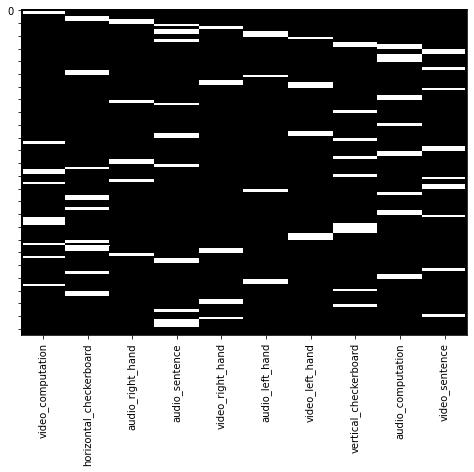

In [4]:
dm.heatmap()

### Convolve with HRF
We can now convolve all of the onset regressors with an HRF function using `.convolve()` method. By default it will convolve all regressors with the standard double gamma HRF function, though you can specify custom ones and also specific regressors to convolve.

When we look at the new heatmap, we can see that our regressors are now a bit blurrier and reflect the shape of the HRF.

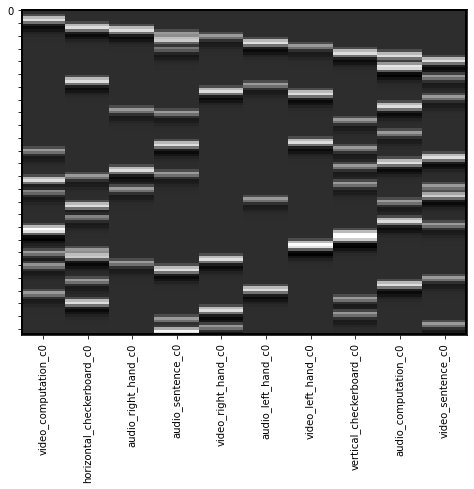

In [5]:
dm_conv = dm.convolve()
dm_conv.heatmap()

### Nuisance covariates
While there are a number of different nusiance covariates one may want to add to their design matrix, today we'll be focusing on removing variance associated with head motion. Since we're working with fmriprep'd data, we can just pull the six motion confounds from the covariates.tsv.

/Users/lizbeard/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


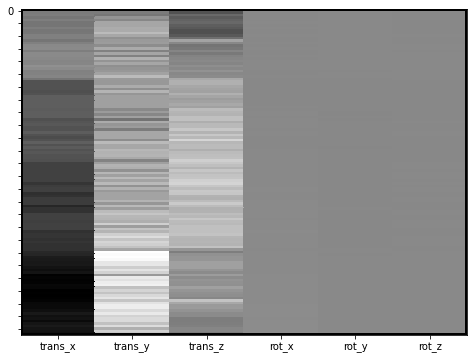

In [6]:
covariates = pd.read_csv(layout.get(subject='S01', scope='derivatives', extension='.tsv')[0].path, sep='\t')

mc = covariates[['trans_x','trans_y','trans_z','rot_x', 'rot_y', 'rot_z']]
mc.fillna(value=0, inplace=True)

cov = Design_Matrix(mc, sampling_freq=1/layout.get_tr())

cov.heatmap()

### Join onsets and covariates
The last step in creating the design matrix involves combining our onsets with our covariates. Because the Design_Matrix class carries the same features as a pandas DataFrame, we can combine them quite easily.

Let's take a look at the final product and save it out!

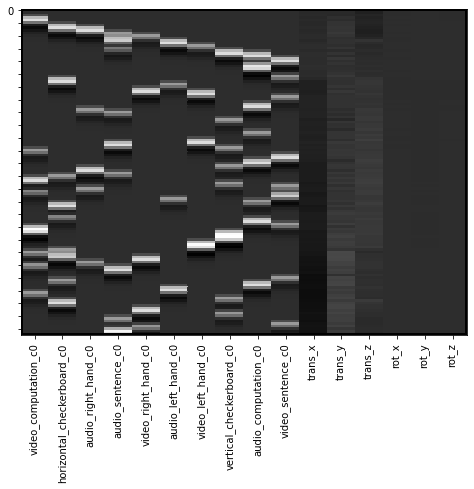

In [7]:
dm_S01 = pd.concat([dm_conv, cov], axis=1)
dm_S01.heatmap()

In [8]:
# add in the filepath to where you'll save the design matrix
dm_S01.to_csv(analysis_dir+'S01-DesignMatrix.csv', index=False)

Now let's loop through our remaining subjects. As an exercise, try and fill in the necessary info we've left blank!

In [ ]:
subj_list = [] # add remaining subjects here

for subj in subj_list:
    
    # load in onsets
    dm = load_bids_events(layout, subj)
    
    # convolve with hrf
    dm_conv = # add convolve function here
    
    # nusiance covariates
    covariates = pd.read_csv(layout.get(subject=subj, scope='derivatives', extension='.tsv')[0].path, sep='\t')

    mc = covariates[['trans_x','trans_y','trans_z','rot_x', 'rot_y', 'rot_z']]
    mc.fillna(value=0, inplace=True)

    cov = Design_Matrix(confounds, sampling_freq=1/layout.get_tr())

    # concatenate the two design matricies
    dm_concat = # combine the two design matricies here
    
    # save the design matrix to the same folder you saved our first subject
    dm_concat.to_csv(file='path/to/%s-DesignMatrix.csv' % subj, index=False) #fill in file path here

In [ ]:
subj_list = ['S02'] # add remaining subjects here

for subj in subj_list:
    
    # load in onsets
    dm = load_bids_events(layout, subj)
    
    # convolve with hrf
    dm_conv = dm.convolve()
    
    # nusiance covariates
    covariates = pd.read_csv(layout.get(subject=subj, scope='derivatives', extension='.tsv')[0].path, sep='\t')

    mc = covariates[['trans_x','trans_y','trans_z','rot_x', 'rot_y', 'rot_z']]
    mc.fillna(value=0, inplace=True)

    cov = Design_Matrix(mc, sampling_freq=1/layout.get_tr())

    # concatenate the two design matricies
    dm_concat = pd.concat([dm_conv, cov], axis=1)
    
    # save the design matrix to the same folder you saved our first subject
    dm_concat.to_csv(analysis_dir+'%s-DesignMatrix.csv' % subj, index=False) #fill in file path here

### **BONUS**: Append runs
*** COMING SOON ***

In [ ]:
# we don't append across runs for this localizer task, so maybe add sample code as an example?

## Estimate GLM for all voxels at the single subject level
Now that we have a design matrix for all of our subjects, we can estimate the regression model for all voxels for all subjects.

### Load brain data
First we'll nead to load in our pre-processed fMRI data. We'll load in the data as an nltools `Brain_Data` object. The Brain_Data class represents neuroimaging data as a vector as opposed to a 3-d matrix like other python based neuroimaging tools, which can make it easier to perform data manipulations. For more information about what the Brain_Data class can do, check out the [DartBrains Glossary](https://dartbrains.org/content/Glossary.html#brain-data).
- ***note***: The default mask for the Brain_Data object is not the same template that is used in the fmriprep registration, so we'll need to use the subject specific mask.

In [9]:
localizer_path = layout.get(subject='S01', task='localizer', scope='derivatives', suffix='bold', extension='.nii.gz')[0].path
localizer_mask = layout.get(subject='S01', task='localizer', scope='derivatives', suffix='mask', extension='.nii.gz')[0].path

data = Brain_Data(localizer_path, mask=localizer_mask)

### Smoothing
To increase the SNR and clean up the data, it's common to apply spatial smoothing. We'll use a traditional 3-d gaussian kernel with a 6mm full width half maximum (FWHM) using the `.smooth()` method.

In [10]:
fwhm = 6
smoothed_S01 = data.smooth(fwhm=fwhm)

We can take a look and compare how this changes the image.

threshold is ignored for simple axial plots


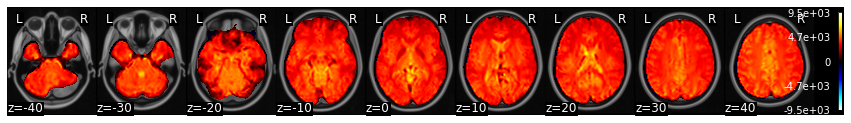

In [11]:
data.mean().plot()

In [17]:
smoothed_S01.mean().plot()

threshold is ignored for simple axial plots


ValueError: Image size of 851x2781537 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1080x144 with 11 Axes>

### Add design matrix
Before we can estimate our model, we need to add our design matrix to the Brain_Data object.

In [ ]:
smoothed_S01.X = dm_S01

### Estimate model for all voxels
Now we can use the `.regress()` method to estimate the regression model for all voxels.

From DartBrains:
> The stats variable is a dictionary with the main results from the regression: a brain image with all of the betas for each voxel, a correspondign image of t-values, p-values, standard error of the estimate, and residuals.The stats variable is a dictionary with the main results from the regression: a brain image with all of the betas for each voxel, a correspondign image of t-values, p-values, standard error of the estimate, and residuals.

In [ ]:
stats_S01 = smoothed_S01.regress()
print(stats_S01.keys())

In [ ]:
stats_S01['beta'][0]

Let's save the image to a nifti file. 
- ***note***: Be sure to update the path you want to save the file to! Try changing the path to your own directory.


In [ ]:
stats_S01['beta'].write(analysis_dir+f'S01_betas_denoised_smoothed{fwhm}_preprocessed_fMRI_bold.nii.gz')

Now let's loop through our remaining subjects. As an exercise, try and fill in the necessary info we've left blank!

In [ ]:
subj_list = [] # add remaining subjects here

for subj in subj_list:
    
    # load in the brain data
    localizer_path = layout.get(subject=subj, task='localizer', scope='derivatives', suffix='bold', extension='.nii.gz')[0].path
    localizer_mask = layout.get(subject=subj, task='localizer', scope='derivatives', suffix='mask', extension='.nii.gz')[0].path

    data = Brain_Data(localizer_path, mask=localizer_mask)
    
    # smooth
    fwhm = 6
    smoothed = data.smooth(fwhm=fwhm)
    
    # add design matrix
    smoothed.X = pd.read_csv(analysis_dir+'%s-DesignMatrix.csv' % subj) # add in the design matrix path here
    
    # save out
    smoothed.write(analysis_dir+f'{subj}_betas_denoised_smoothed{fwhm}_preprocessed_fMRI_bold.nii.gz')


In [ ]:
subj_list = ['S02'] # add remaining subjects here

for subj in subj_list:
    
    # load in the brain data
    localizer_path = layout.get(subject=subj, task='localizer', scope='derivatives', suffix='bold', extension='.nii.gz')[0].path
    localizer_mask = layout.get(subject=subj, task='localizer', scope='derivatives', suffix='mask', extension='.nii.gz')[0].path

    data = Brain_Data(localizer_path, mask=localizer_mask)
    
    # smooth
    fwhm = 6
    smoothed = data.smooth(fwhm=fwhm)
    
    # add design matrix
    smoothed.X = pd.read_csv(analysis_dir+'%s-DesignMatrix.csv' % subj) # add in the design matrix path here
    
    stats_subj = smoothed.regress()
    
    # save out
    stats_subj['beta'].write(analysis_dir+f'{subj}_betas_denoised_smoothed{fwhm}_preprocessed_fMRI_bold.nii.gz')

### Create contrast
Now that we have estimated our model, we will likely want to create contrasts to examine brain activation to different conditionsNow that we have estimated our model, we will likely want to create contrasts to examine brain activation to different conditions. Let's take a look at which regions are more involved with visual compared to auditory sensory processing.

In [ ]:
import numpy as np

In [ ]:
print(smoothed_S01.X.columns)
c1 = np.zeros(len(stats_S01['beta']))
c1[[2,3,4,8]] = -1/4 # auditory
c1[[0,4,6,9]] = 1/4 # visual

vis_aud_S01 = stats_S01['beta'] * c1

### Visualization
What do you see? Try playing around with different thresholds.

In [ ]:
vis_aud_S01.iplot()

Let's save this contrast to use for our group-level analysis.

In [ ]:
vis_aud_S01.write(analysis_dir+f'S01_betas_vis_aud.nii.gz')

Finally, let's run this for all of our subjects using the data we saved out earlier. Note that because the design matrix is no longer attached to the Brain_Data object, we won't be able to reference it. This won't matter here since we already know the order of the betas and contrasts we want to run.

In [ ]:
subj_list = ['S02']

for subj in subj_list:
    stats_subj = Brain_Data(analysis_dir+f'{subj}_betas_denoised_smoothed{fwhm}_preprocessed_fMRI_bold.nii.gz')

    c1 = np.zeros(len(stats_subj))
    c1[[2,3,4,8]] = -1/4 # auditory
    c1[[0,4,6,9]] = 1/4 # visual

    vis_aud = stats_subj * c1
    # save out
    vis_aud.write(analysis_dir+f'{subj}_betas_vis_aud.nii.gz')

# Second Level Analysis - Group Data

In [ ]:
subjs_list = ['sub-S01', 'sub-S02']

analysis_dir = data_dir + 'derivatives/cog_analysis/'

## Random-effects GLM

### Load first-level data for each subject

In [ ]:
beta_list_all = glob.glob(os.path.join(all_runs_dir, 'S0*betas_*'))
beta_list_all.sort()
beta_dat_all = Brain_Data(beta_list_all)

print('Found a total of '+str(len(beta_list_all))+' files for '+str(len(subjs_list))+' subjects.')

### Calculate the mean activation in each voxel across participants

### Perform one-sample t-test across all voxels

In [ ]:
t_stats_all = beta_dat_all.ttest()
t_stats_all['t'].write(os.path.join(analysis_dir,'group','tmap.nii.gz'))
    

## T-test
All conditions vs rest (fixation)

In [ ]:
cont_list_all = glob(os.path.join(all_runs_dir, 'sub-*', 'tmap_relVfix.nii'))
cont_list_all.sort()
cont_dat_all = Brain_Data(cont_list_all, mask="derivatives/fmriprep/sub-301/ses-001/func/sub-301_ses-001_task-relscenarios_run-001_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz")

t_stats_all = cont_dat_all.ttest()
t_stats_all['t'].write(os.path.join(all_runs_dir,'group','tmap_relVfix.nii'))


# Conclusion

#outro video